[APW+20a](https://arxiv.org/abs/2002.00014) published a catalog of ~20k binaries from 230k APOGEE systems.

and they include a CMD that shows interesting structure, not unlike ours.

It's worth comparing! But we'll need to xmatch their sample to Gaia (thankfully [ASCAP](https://www.sdss.org/dr16/irspec/spectro_data/#SummaryCatalogs) did this for us)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import LogNorm
from astropy.table import Table, join

import sys
sys.path.append('/Users/james/python/qthist2d/')
from qthist2d import qthist, qtcount

sys.path.append('/Users/james/python/cubehelix/')
import cubehelix 

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

## prep APW binaries

In [3]:
Abins_file = '../data/apw20/metadata.fits' # all the stars they searched
ascap_file = '../data/allStarLite-r12-l33.fits' # all the stars in ASCAP

Abins = Table.read(Abins_file, format='fits')
len(Abins)

232495

In [4]:
ascap = Table.read(ascap_file, format='fits')
len(ascap)

473307

In [5]:
bigtable = join(Abins, ascap, keys='APOGEE_ID')
len(bigtable)

263455

(257355,)


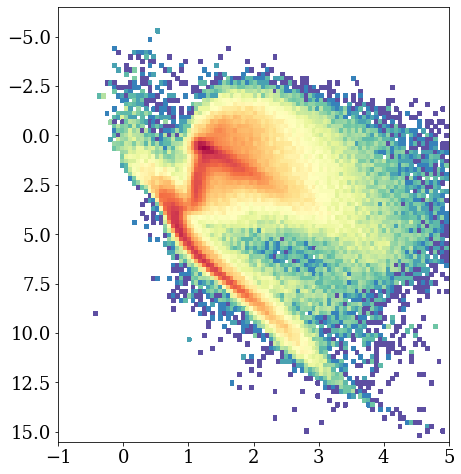

In [6]:
aok = np.where(np.isfinite(bigtable['GAIA_PHOT_BP_MEAN_MAG'] - bigtable['GAIA_PHOT_RP_MEAN_MAG']) & 
               np.isfinite(bigtable['GAIA_PHOT_G_MEAN_MAG']) & 
               np.isfinite(bigtable['GAIA_R_EST']) & 
               (bigtable['GAIA_R_EST'] > 0) & 
               (bigtable['GAIA_PHOT_BP_MEAN_MAG'] > -10) & 
               (bigtable['GAIA_PHOT_RP_MEAN_MAG'] > -10) )[0]

print(aok.shape)

fig = plt.figure(figsize=(8,8))
_=plt.hist2d(bigtable['GAIA_PHOT_BP_MEAN_MAG'][aok] - bigtable['GAIA_PHOT_RP_MEAN_MAG'][aok], 
           bigtable['GAIA_PHOT_G_MEAN_MAG'][aok] - 5.*np.log10(bigtable['GAIA_R_EST'][aok]) + 5, 
           range=[[-1,5],[-6.5,15.5]], bins=100, cmap=plt.cm.Spectral_r, norm=LogNorm())

plt.gca().invert_yaxis()

In [7]:
np.sum(bigtable['binary_catalog'] == False)

238077

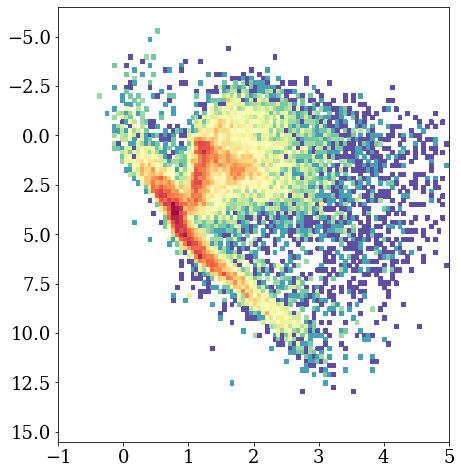

In [8]:
isBin = (bigtable['binary_catalog'][aok] == True)
isNot = (bigtable['binary_catalog'][aok] == False)

fig = plt.figure(figsize=(8,8))
_=plt.hist2d(bigtable['GAIA_PHOT_BP_MEAN_MAG'][aok][isBin] - bigtable['GAIA_PHOT_RP_MEAN_MAG'][aok][isBin], 
           bigtable['GAIA_PHOT_G_MEAN_MAG'][aok][isBin] - 5.*np.log10(bigtable['GAIA_R_EST'][aok][isBin]) + 5, 
           range=[[-1,5],[-6.5,15.5]], bins=100, cmap=plt.cm.Spectral_r, norm=LogNorm())

plt.gca().invert_yaxis()

In [70]:
x = bigtable['GAIA_PHOT_BP_MEAN_MAG'][aok][isBin] - bigtable['GAIA_PHOT_RP_MEAN_MAG'][aok][isBin]
y = bigtable['GAIA_PHOT_G_MEAN_MAG'][aok][isBin] - 5.*np.log10(bigtable['GAIA_R_EST'][aok][isBin]) + 5

num, xmin0, xmax0, ymin0, ymax0 = qthist(x,y, N=7, thresh=50, density=False, rng=[[-1.1,4.1],[-6,15]])

x2 =  bigtable['GAIA_PHOT_BP_MEAN_MAG'][aok][isNot] - bigtable['GAIA_PHOT_RP_MEAN_MAG'][aok][isNot]
y2 =  bigtable['GAIA_PHOT_G_MEAN_MAG'][aok][isNot] - 5.*np.log10(bigtable['GAIA_R_EST'][aok][isNot]) + 5

# using Quad Tree bins defined from EB sample, count the background sample
num2 = qtcount(x2, y2, xmin0, xmax0, ymin0, ymax0, density=False)

In [71]:
def EBscore(num, num2, xmin, xmax, ymin, ymax):
    '''
    compute the Eclipsing Binary rarity score
    assumes the number counts in each bin are NOT densities
    '''
    areas = np.abs(ymax - ymin) * np.abs(xmax - xmin)
    d_EB = num / areas / num.sum() + 1
    d_bk = num2 / areas / num2.sum() + 1
    SCORE = 1 - (d_EB/d_bk)
    return SCORE*100

def EBfrac(num, num2):
    '''
    compute the Binary Fraction (simple)
    '''
    SCORE = num / (num+num2)
    return SCORE

In [72]:
SCORE = EBscore(num, num2, xmin0, xmax0, ymin0, ymax0)

# clip the distribution, center about SCORE=0...
if -np.min(SCORE) > np.max(SCORE):
    SCORE[-SCORE > np.max(SCORE)] = -np.max(SCORE)

if np.max(SCORE) > -np.min(SCORE):
    SCORE[np.max(SCORE) > -np.min(SCORE)] = -np.min(SCORE)

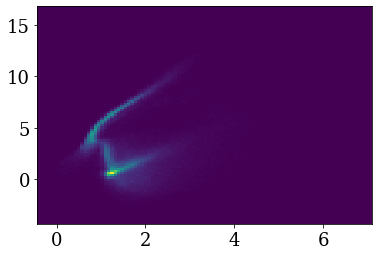

In [73]:
zz2, xx2, yy2, img = plt.hist2d(x2,y2, bins=100)

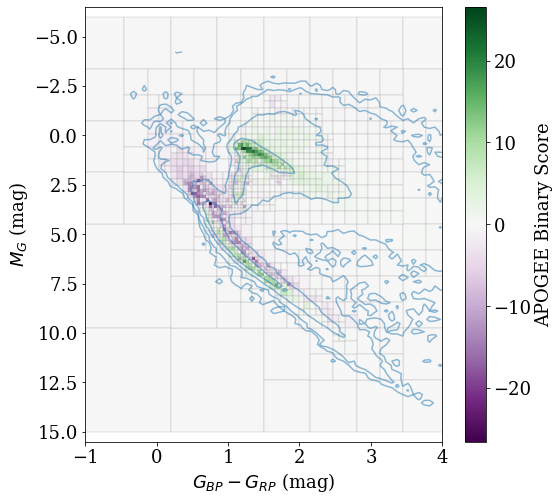

In [74]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
CMAP = plt.cm.PRGn

# if doing the 2d Histogram for background (fast, but ratty)
plt.contour((xx2[1:]+xx2[:-1])/2., (yy2[1:]+yy2[:-1])/2., 
            zz2.T / np.sum(zz2)*np.float(len(x2)), colors='C0', alpha=0.5, 
            levels=(3,10,100,500))

# scale SCORE to [0,1] for color codes
clr = (SCORE - np.nanmin(SCORE)) / (np.nanmax(SCORE) - np.nanmin(SCORE))
for k in range(len(SCORE)):
    ax.add_patch(plt.Rectangle((xmin0[k], ymin0[k]), xmax0[k]-xmin0[k], ymax0[k]-ymin0[k], 
                               color=CMAP(clr[k]), ec='grey', lw=0.2, ))

# create a fake image to show, just to invoke colormap
img = plt.imshow(np.array([[clr.min(), clr.max()]]), cmap=CMAP, aspect='auto', 
                 vmin=SCORE.min(),vmax=SCORE.max()) # scale to the "SCORE"
img.set_visible(False) # throw this away
cb = plt.colorbar()
cb.set_label('APOGEE Binary Score')

plt.gca().invert_yaxis()
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')
# plt.grid(True)

# plt.xlim(min(x), max(x))
# plt.ylim(max(y), min(y))
plt.ylim(15.5,-6.5)
plt.xlim(-1,4)
plt.savefig('APW_EBscore.pdf', dpi=300, bbox_inches='tight', pad_inches=0.25)

/Users/james/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/Users/james/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


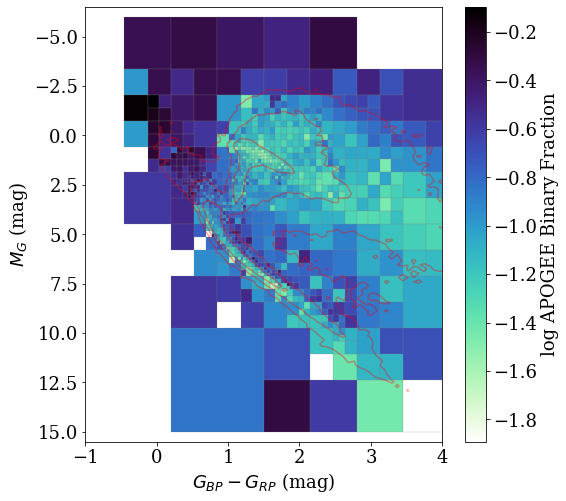

In [75]:
SCORE = np.log10(EBfrac(num, num2))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#https://ifweassume.blogspot.com/2014/04/cubehelix-colormap-for-python.html
CMAP = cubehelix.cmap(start=0.5, rot=-0.6, sat=1.8, reverse=True)

# if doing the 2d Histogram for background (fast, but ratty)
plt.contour((xx2[1:]+xx2[:-1])/2., (yy2[1:]+yy2[:-1])/2., 
            zz2.T / np.sum(zz2)*np.float(len(x2)), colors='r', alpha=0.35, 
            levels=(10,100,500))

Sok = np.isfinite(SCORE)
# scale SCORE to [0,1] for color codes
clr = (SCORE - np.nanmin(SCORE[Sok])) / (np.nanmax(SCORE[Sok]) - np.nanmin(SCORE[Sok]))
for k in range(len(SCORE)):
    if np.isfinite(SCORE[k]):
        ax.add_patch(plt.Rectangle((xmin0[k], ymin0[k]), xmax0[k]-xmin0[k], ymax0[k]-ymin0[k], 
                                   color=CMAP(clr[k]), ec='grey', lw=0.2, ))

# create a fake image to show, just to invoke colormap
img = plt.imshow(np.array([[clr.min(), clr.max()]]), cmap=CMAP, aspect='auto', 
                 vmin=SCORE[Sok].min(),vmax=SCORE[Sok].max()) # scale to the "SCORE"
img.set_visible(False) # throw this away
cb = plt.colorbar()
cb.set_label('log APOGEE Binary Fraction')

plt.gca().invert_yaxis()
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')

plt.ylim(15.5,-6.5)
plt.xlim(-1,4)
plt.savefig('APW_frac.pdf', dpi=300, bbox_inches='tight', pad_inches=0.25)

In [76]:
# now re-do using the binning from the TESS data
df_prev = pd.read_csv('TESS_EB_qthist_v2.2.csv')
df_prev
# num = df_prev['num_bin'].values
# num2 = df_prev['num_bkg'].values
xmin = df_prev['xmin'].values
xmax = df_prev['xmax'].values
ymin = df_prev['ymin'].values
ymax = df_prev['ymax'].values

num = qtcount(x, y, xmin, xmax, ymin, ymax, density=False)
num2 = qtcount(x2, y2, xmin, xmax, ymin, ymax, density=False)

SCORE = EBscore(num, num2, xmin,xmax,ymin,ymax)

# clip the distribution, center about SCORE=0...
if -np.min(SCORE) > np.max(SCORE):
    SCORE[-SCORE > np.max(SCORE)] = -np.max(SCORE)

if np.max(SCORE) > -np.min(SCORE):
    SCORE[np.max(SCORE) > -np.min(SCORE)] = -np.min(SCORE)

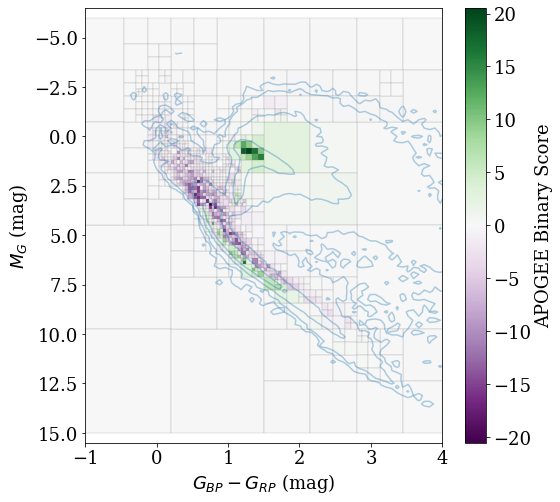

In [77]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
CMAP = plt.cm.PRGn

# if doing the 2d Histogram for background (fast, but ratty)
plt.contour((xx2[1:]+xx2[:-1])/2., (yy2[1:]+yy2[:-1])/2., 
            zz2.T / np.sum(zz2)*np.float(len(x2)), colors='C0', alpha=0.35, 
            levels=(3,10,100,500))

# scale SCORE to [0,1] for color codes
clr = (SCORE - np.nanmin(SCORE)) / (np.nanmax(SCORE) - np.nanmin(SCORE))
for k in range(len(SCORE)):
    ax.add_patch(plt.Rectangle((xmin[k], ymin[k]), xmax[k]-xmin[k], ymax[k]-ymin[k], 
                               color=CMAP(clr[k]), ec='grey', lw=0.2, ))

# create a fake image to show, just to invoke colormap
img = plt.imshow(np.array([[clr.min(), clr.max()]]), cmap=CMAP, aspect='auto', 
                 vmin=SCORE.min(),vmax=SCORE.max()) # scale to the "SCORE"
img.set_visible(False) # throw this away
cb = plt.colorbar()
cb.set_label('APOGEE Binary Score')

plt.gca().invert_yaxis()
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')

plt.ylim(15.5,-6.5)
plt.xlim(-1,4)
plt.savefig('APW_EBscore_TESSbins.pdf', dpi=300, bbox_inches='tight', pad_inches=0.25)

In [78]:
# now compare the spectroscopic QThist w/ the eclipsing...
SCORE_TESS = EBfrac(df_prev['num_bin'].values, df_prev['num_bkg'].values)#, xmin,xmax,ymin,ymax)
SCORE_Spec = EBfrac(num, num2)
SCORE = np.log10(SCORE_Spec)

/Users/james/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/Users/james/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


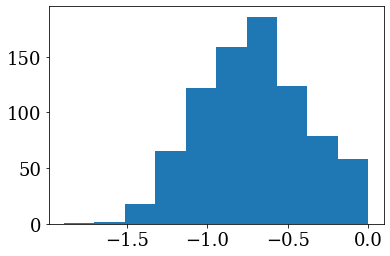

In [79]:
_= plt.hist(np.log10(SCORE_Spec[SCORE_Spec > 0]))

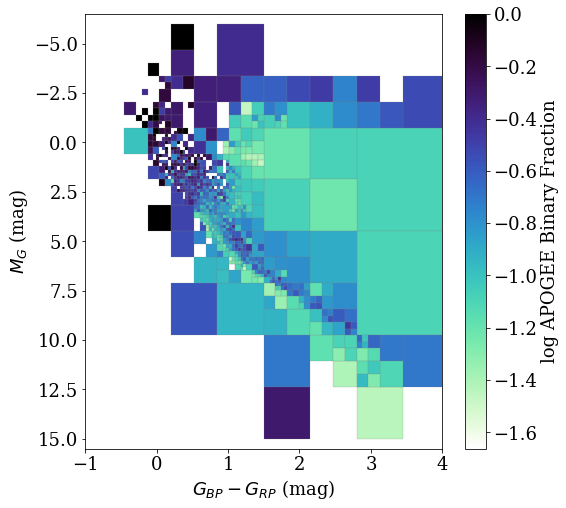

In [80]:
if sum(~np.isfinite(SCORE)) > 0:
    SCORE[~np.isfinite(SCORE)] = -2
SCORE[num < 2] = np.nan

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
# CMAP = plt.cm.PRGn

#https://ifweassume.blogspot.com/2014/04/cubehelix-colormap-for-python.html
CMAP = cubehelix.cmap(start=0.5, rot=-0.6, sat=1.8, reverse=True)

# if doing the 2d Histogram for background (fast, but ratty)
# plt.contour((xx2[1:]+xx2[:-1])/2., (yy2[1:]+yy2[:-1])/2., 
#             zz2.T / np.sum(zz2)*np.float(len(x2)), colors='C0', alpha=0.35, 
#             levels=(3,10,100,500))

Sok = np.isfinite(SCORE)
# scale SCORE to [0,1] for color codes
clr = (SCORE - np.nanmin(SCORE[Sok])) / (np.nanmax(SCORE[Sok]) - np.nanmin(SCORE[Sok]))
for k in range(len(SCORE)):
    if np.isfinite(SCORE[k]):
        ax.add_patch(plt.Rectangle((xmin[k], ymin[k]), xmax[k]-xmin[k], ymax[k]-ymin[k], 
                                   color=CMAP(clr[k]), ec='grey', lw=0.2, ))

# create a fake image to show, just to invoke colormap
img = plt.imshow(np.array([[clr.min(), clr.max()]]), cmap=CMAP, aspect='auto', 
                 vmin=SCORE[Sok].min(),vmax=SCORE[Sok].max()) # scale to the "SCORE"
img.set_visible(False) # throw this away
cb = plt.colorbar()
cb.set_label('log APOGEE Binary Fraction')

plt.gca().invert_yaxis()
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')

plt.ylim(15.5,-6.5)
plt.xlim(-1,4)
plt.savefig('APW_frac_TESSbins.pdf', dpi=300, bbox_inches='tight', pad_inches=0.25)

/Users/james/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


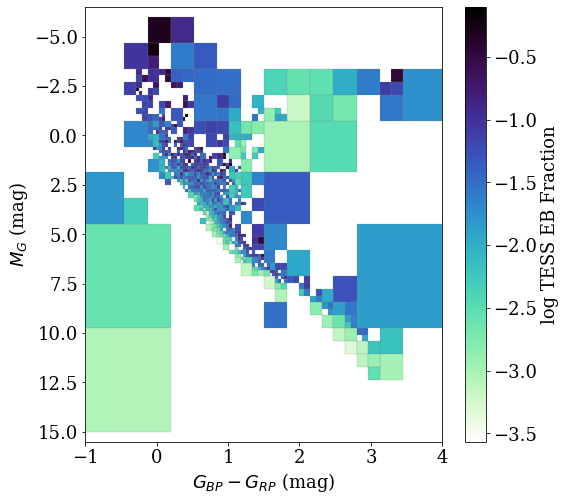

In [81]:
SCORE = np.log10(SCORE_TESS)
# if sum(~np.isfinite(SCORE)) > 0:
#     SCORE[~np.isfinite(SCORE)] = -4
SCORE[df_prev['num_bin'].values < 1] = np.nan

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
# CMAP = plt.cm.PRGn

#https://ifweassume.blogspot.com/2014/04/cubehelix-colormap-for-python.html
CMAP = cubehelix.cmap(start=0.5, rot=-0.6, sat=1.8, reverse=True)

# if doing the 2d Histogram for background (fast, but ratty)
# plt.contour((xx2[1:]+xx2[:-1])/2., (yy2[1:]+yy2[:-1])/2., 
#             zz2.T / np.sum(zz2)*np.float(len(x2)), colors='C0', alpha=0.35, 
#             levels=(3,10,100,500))

Sok = np.isfinite(SCORE)
# scale SCORE to [0,1] for color codes
clr = (SCORE - np.nanmin(SCORE[Sok])) / (np.nanmax(SCORE[Sok]) - np.nanmin(SCORE[Sok]))
for k in range(len(SCORE)):
    if np.isfinite(SCORE[k]):
        ax.add_patch(plt.Rectangle((xmin[k], ymin[k]), xmax[k]-xmin[k], ymax[k]-ymin[k], 
                                   color=CMAP(clr[k]), ec='grey', lw=0.2, ))

# create a fake image to show, just to invoke colormap
img = plt.imshow(np.array([[clr.min(), clr.max()]]), cmap=CMAP, aspect='auto', 
                 vmin=SCORE[Sok].min(),vmax=SCORE[Sok].max()) # scale to the "SCORE"
img.set_visible(False) # throw this away
cb = plt.colorbar()
cb.set_label('log TESS EB Fraction')

plt.gca().invert_yaxis()
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')

plt.ylim(15.5,-6.5)
plt.xlim(-1,4)
plt.savefig('TESS_frac_TESSbins.pdf', dpi=300, bbox_inches='tight', pad_inches=0.25)

/Users/james/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/james/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/james/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0, 'log$_{10}$ (EB frac / Spec frac)')

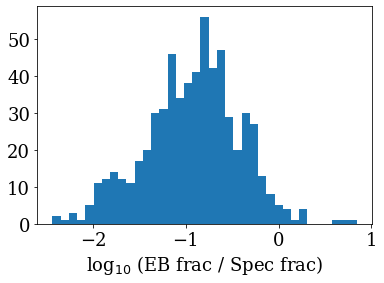

In [82]:
SCORE_new = SCORE_TESS / SCORE_Spec

# if sum(~np.isfinite(SCORE_new)) > 0:
#     SCORE_new[~np.isfinite(SCORE_new)] = 0
    
# smax = 2
# SCORE_new[SCORE_new > smax] = smax
   
# SCORE_new[num < 4] = 0 
  
logscore = np.log10(SCORE_new)
_ = plt.hist(logscore[np.isfinite(logscore)],bins=37)
plt.xlabel('log$_{10}$ (EB frac / Spec frac)')

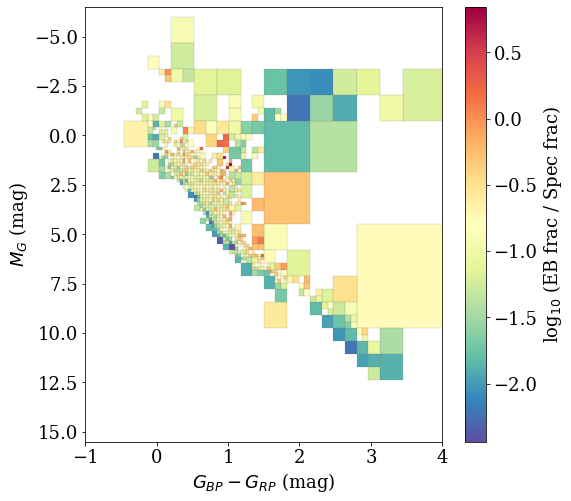

In [93]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
CMAP = plt.cm.Spectral_r
# CMAP = plt.cm.plasma_r

# if doing the 2d Histogram for background (fast, but ratty)
# plt.contour((xx2[1:]+xx2[:-1])/2., (yy2[1:]+yy2[:-1])/2., 
#             zz2.T / np.sum(zz2)*np.float(len(x2)), colors='C0', alpha=0.35, 
#             levels=(10,100,500))

SCORE_new = logscore
lok = np.isfinite(SCORE_new)

# scale SCORE to [0,1] for color codes
clr = (SCORE_new - np.nanmin(SCORE_new[lok])) / (np.nanmax(SCORE_new[lok]) - np.nanmin(SCORE_new[lok]))
for k in range(len(SCORE_new)):
    if np.isfinite(SCORE_new[k]):
        ax.add_patch(plt.Rectangle((xmin[k], ymin[k]), xmax[k]-xmin[k], ymax[k]-ymin[k], 
                                   color=CMAP(clr[k]), ec='grey', lw=0.2, ))

# create a fake image to show, just to invoke colormap
img = plt.imshow(np.array([[clr.min(), clr.max()]]), cmap=CMAP, aspect='auto', 
                 vmin=np.nanmin(logscore[lok]),vmax=np.nanmax(logscore[lok])) # scale to the "SCORE"
img.set_visible(False) # throw this away
cb = plt.colorbar()
cb.set_label('log$_{10}$ (EB frac / Spec frac)')

plt.gca().invert_yaxis()
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')

plt.ylim(15.5,-6.5)
plt.xlim(-1,4)
plt.savefig('APW_compare.pdf', dpi=300, bbox_inches='tight', pad_inches=0.25)